# Milestone 2 - CS109B Project Group 29
**"Predicting Movie Genres"**<br>
**CS109B (Spring 2017) Final Project Group 29**<br>
Calvin J Chiew, Tim Hagmann, Ji Hua<br>
TF: Rashmi Banthia<br>

## Deliverables

- Discussion about the imbalanced nature of the data and how you want to address it
- Description of your data
- What does your choice of Y look like?
- Which features do you choose for X and why?
- How do you sample your data, how many samples, and why?

## Import Libraries

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
from bs4 import BeautifulSoup
import urllib
from urllib import urlopen
from urllib import urlretrieve
import threading
from threading import Timer
from time import time, sleep
import io
import imdb

## Data Sampling

### Scraping from TMDb

First, we used the TMDb API to scrape information on movies that have `tmdb_id` of 1 through 160,000 (see Milestone 1 for code). About 60,000 of these `tmdb_id`'s were empty, returning about 100,000 actual records.

Given that `tmdb_id`'s are not assigned in chronological order or in any particular pattern, this 100,000 movies represent a **random** sample of all movies listed on TMDb (estimated to be around 300,000). We chose 100,000 as we believe it is a sufficiently large sample size to develop our traditional ML and deep learning models.

We dropped about 30,000 records that were missing poster paths and `imdb_id`'s, leaving us with about 70,000 movies.

You can download the raw data file we gathered on our GitHub repository here: https://github.com/greenore/deep-learning-project/blob/master/milestone2/tmdb_movie_info_100k.txt

In [57]:
# view example
tmdb = pd.read_table('tmdb_movie_info_100k.txt')
tmdb.head()

,tmdb_id,imdb_id,title,plot,poster_path,release_date,budget,revenue,runtime,popularity,user_rating,production_company,genres
0,2,0094675,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg,1988-10-21,0.0,0.0,69,0.623849,6.8,"Villealfa Filmproduction Oy,Finnish Film Found...","Drama,Crime"
1,3,0092149,Shadows in Paradise,"An episode in the life of Nikander, a garbage ...",/7ad4iku8cYBuB08g9yAU7tHJik5.jpg,1986-10-16,0.0,0.0,76,0.288572,6.8,Villealfa Filmproduction Oy,"Drama,Comedy"
2,5,0113101,Four Rooms,It's Ted the Bellhop's first night on the job....,/eQs5hh9rxrk1m4xHsIz1w11Ngqb.jpg,1995-12-25,4000000.0,4300000.0,98,1.768986,6.4,"Miramax Films,A Band Apart","Crime,Comedy"
3,6,0107286,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",/lNXmgUrP6h1nD53gkFh4WDzT6RZ.jpg,1993-10-15,0.0,12136938.0,110,0.676269,6.6,"Largo Entertainment,JVC Entertainment Networks","Action,Thriller,Crime"
4,8,0825671,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,/8YyIjOAxwzD3fZMdmJrfiApod4l.jpg,2006-01-01,42000.0,0.0,80,0.125477,5.2,inLoops,Documentary


### Scraping from IMDb

We also extracted additional metadata from IMDb for this list of 70,000 movies and matched them to the TMDb records based on `imdb_id`.

In [3]:
imdb_df = pd.read_table('imdb_id_100k.txt', sep='\t')
imdb_df.head()

,tmdb_id,imdb_id
0,2,0094675
1,3,0092149
2,5,0113101
3,6,0107286
4,8,0825671


In [4]:
imdb_df.shape

(69970, 2)

In [ ]:
movie = IMDb()
target = io.open("imdb_movie_info_100k.txt", 'w',encoding="utf8")
line=u"tmdb_id\timdb_id\tcast\tdirector\twriter\tUSA_rating"
target.write(line+'\n')

for i in range(1,imdb_df.shape[0]):
    tmdb_id=imdb_df.iloc[i,0]
    imdb_id=imdb_df.iloc[i,1]
    data=movie.get_movie(imdb_id)
    line=u""
    line=line+str(tmdb_id).decode('utf8') #tmdb_id
    line=line+u"\t"+str(imdb_id).decode('utf8')#imdb_id

    ## get cast
    cast_string=u""
    try:
        cast_num=min(len(data['cast']),5)
        for c in range(cast_num):
            if c==0:
                cast_string=str(data['cast'][c].personID).decode('utf8')
            else:
                cast_string=cast_string+","+str(data['cast'][c].personID).decode('utf8')
    except KeyError:
         cast_string=u""
    line=line+u"\t"+cast_string

    #get director
    director_string=u""
    try:
        director_num=min(len(data['director']),2)
        for c in range(director_num):
            if c==0:
                director_string=str(data['director'][c].personID).decode('utf8')
            else:
                director_string=director_string+","+str(data['director'][c].personID).decode('utf8')
    except KeyError:
        director_string=u""
    line=line+u"\t"+director_string

    # get writer
    writer_string=u""
    try:
        writer_num=min(len(data['writer']),2)
        for c in range(writer_num):
            if c==0:
                writer_string=str(data['writer'][c].personID).decode('utf8')
            else:
                writer_string=writer_string+","+str(data['writer'][c].personID).decode('utf8')
    except KeyError:
        writer_string=u""
    line=line+u"\t"+writer_string

    ## get US certificate
    try:
        matching = [s for s in data['certificates'] if "USA" in s]
        if matching!=[]:
            usa_rating=matching[0].split(":")[1]
        else:
            usa_rating=u""
    except KeyError:
        usa_rating=u""
    line=line+u"\t"+usa_rating
    target.write(line+'\n')
    target.flush()
    print i
        
        
target.close()

Using the code above, we were able to gather additional metadata (cast, director, writer, picture rating) from IMDb. Information on cast, directors and writers are in the format of personID (7-digit numbers) used by IMDb.

You can download the raw data file we gathered on our GitHub repository here: https://github.com/greenore/deep-learning-project/blob/master/milestone2/imdb_movie_info_100k.txt

In [7]:
# view example
imdb = pd.read_table('imdb_movie_info_100k.txt')
imdb.head()

,tmdb_id,imdb_id,cast,director,writer,USA_rating
0,2,94675,"0656999,0352099,0671231,0383990,0656998",0442454,0442454,Not Rated
1,3,92149,"0671231,0653669,0475411,0631741,0477871",0442454,0442454,NaN
2,5,113101,"0205423,0004866,0000420,0000187,0001746","0025978,0734319","0025978,0734319",R
3,6,107286,"0000389,0000421,0001459,0001151,0005315",0394280,"0171474,0192342",R
4,8,825671,NaN,1119183,"0322198,1119183",NaN


In [8]:
# split cast into columns
cast = imdb['cast'].str.split(',').apply(pd.Series).astype(str)
cast.rename(columns={0:'cast1', 1:'cast2', 2:'cast3', 3:'cast4', 4:'cast5'}, inplace=True)

# split director into columns
directors = imdb['director'].str.split(',').apply(pd.Series).astype(str)
directors.rename(columns={0:'director1', 1:'director2'}, inplace=True)

# split writers into columns
writers = imdb['writer'].str.split(',').apply(pd.Series).astype(str)
writers.rename(columns={0:'writer1', 1:'writer2'}, inplace=True)

# concatenate relevant columns
imdb_info = pd.concat([imdb[['tmdb_id', 'USA_rating']], cast, directors, writers], axis=1)

# show head
imdb_info.head()

,tmdb_id,USA_rating,cast1,cast2,cast3,cast4,cast5,director1,director2,writer1,writer2
0,2,Not Rated,0656999,0352099,0671231,0383990,0656998,0442454,nan,0442454,nan
1,3,NaN,0671231,0653669,0475411,0631741,0477871,0442454,nan,0442454,nan
2,5,R,0205423,0004866,0000420,0000187,0001746,0025978,0734319,0025978,0734319
3,6,R,0000389,0000421,0001459,0001151,0005315,0394280,nan,0171474,0192342
4,8,NaN,nan,nan,nan,nan,nan,1119183,nan,0322198,1119183


---

## Outcome Variables (Y)

The outcome variable is the movie genre, which is classified into 19 categories by TMDb (namely Adventure, Fantasy, Animation, Drama, Horror, Action, Comedy, History, Western, Thriller, Crime, Documentary, Science Fiction, Mystery, Music, Romance, Family, War and Foreign). We decided against regrouping the genres because even if we had chosen to do so, we would have only collapsed a few groups (eg. Action-Adventure, Thriller-Crime-Mystery) based on our genre pair analysis in earlier EDA (see Milestone 1). We did not feel that this small reduction in genre categories would make a significant difference in the larger picture. To simplify the problem, we also did not use the genre classifications on IMDb.

In addition, each movie may fall into multiple genres, ie. this is a multi-label problem. To address this issue, we coded the outcome into 19 columns of binary (1/0) flags, one for each of the 19 TMDb genres.

In [26]:
# load pre-processed file
genres = pd.read_csv('genres_70k_new.txt')

# drop TVMovie as 0 observations
genres = genres.drop('TVMovie', 1)

# show example
genres.head()

,tmdb_id,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign
0,7621,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,14734,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,20401,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,20979,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0
4,21726,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In addition to the 19 outcome variables (one for each genre), we created 1 more outcome variable -- the **number of genre tags**. As we will be training separate classification models for each genre, we would like another model that can predict the number of genres to be assigned to each movie. Using this predicted number, we can then assign tags to each test movie with predicted probabilities of every genre. Here, we generate this 20th outcome variable.

In [27]:
# generate new Y variable -- number of genres
genres['num_genres'] = genres.ix[:, 1:19].sum(axis=1)
genres.head()

,tmdb_id,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,...,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign,num_genres
0,7621,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2
1,14734,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2
2,20401,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,2
3,20979,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,3
4,21726,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [28]:
genres.shape

(69970, 21)

In [32]:
genres.to_csv('outcome_vars.csv')

---

## Predictor Variables (X)

We have two sets of data, one with movie posters as features, and the other with movie metadata. For the former, we downloaded w500 resolution movie posters from TMDb (see below). For the latter, we have chosen to include the following features:

*Extracted from TMDb*
- Title
- Plot summary
- Production company
- Release date
- Runtime (mins)
- Budget (USD)
- Revenue (USD)
- Popularity
- Average user rating (on scale of 1-10)

*Extracted from IMDb*
- Director (first 2 names listed)
- Writer (first 2 names listed)
- Cast (first 5 names listed)
- Picture rating (US MPAA categories eg. PG-13, R-21)

These features were chosen based on our prior beliefs about what are potential predictors of movie genre (see Milestone 1).

### Downloading Posters from TMDb

Using the code below, we downloaded w500 resolution movie posters in `.jpg` format from TMDb. Since the total file size is >1GB, we have not added them to GitHub repository. We have included a few posters as examples below.

In [17]:
poster_df = pd.read_table('poster_path_100k.txt', sep='\t')
poster_df.head()

,tmdb_id,poster_path
0,2,/gZCJZOn4l0Zj5hAxsMbxoS6CL0u.jpg
1,3,/7ad4iku8cYBuB08g9yAU7tHJik5.jpg
2,5,/eQs5hh9rxrk1m4xHsIz1w11Ngqb.jpg
3,6,/lNXmgUrP6h1nD53gkFh4WDzT6RZ.jpg
4,8,/8YyIjOAxwzD3fZMdmJrfiApod4l.jpg


In [ ]:
base="https://image.tmdb.org/t/p/w500"
filebase="G:/data/clean_data/poster/"
count=0
for i in range(64208,poster_df.shape[0]):
    poster_path=poster_df.iloc[i,1]
    filename=str(poster_df.iloc[i,0])+".jpg"
    urlretrieve(base+poster_path, filebase+filename)
    count+=1
    if count%100==0:
        print count

| Poster Examples |
|---|---|---|---|---|---|---|
| <img src="26.jpg" width="150"> | <img src="33.jpg" width="150"> | <img src="35.jpg" width="150"> | <img src="38.jpg" width="150"> | <img src="58.jpg" width="150"> | <img src="59.jpg" width="150"> | <img src="62.jpg" width="150">

---

## Converting Posters to Features

In this section, we convert the poster `.jpg` images to arrays of pixel features. All the posters had a width of 500 pixels. Most of them had a height of 750 pixels. To ensure a standard array size for each poster, we only considered the first 750 pixels (and ignored the rest) if the poster was taller than 750 pixels. If the poster was shorter than 750 pixels, we filled it with black pixels at the bottom until a height of 750 pixels.

Each poster had 500 x 750 = 375,000 pixels, and for each pixel, we extracted 3 colour (RGB) values. Therefore, each poster had a total of 375,000 x 3 = 1,125,000 features at the end.

To limit output file sizes, we processed the posters in batches of 500 posters (total 140 batches).

Since the file size of each output matrix is very large, we did not add them to GitHub repository. We show an example of one matrix (first 500 posters) below.

In [ ]:
from scipy import misc
labels=['tmdb_id']
color=['r','g','b']
for c in color:
    for i in range(500*750): ## resolution maxium is 500*750
        label=c+str(i)
        labels.append(label)

In [ ]:
target = open("G:/data/clean_data/poster_matrix.txt", 'w')
for label in labels:
    if label!=labels[-1]:
        target.write(label+"\t")
    else:
        target.write(label+"\n")
target.flush()

In [ ]:
n_group=100 # 250 poster as a file
total_groups=poster_df.shape[0]/n_group+1 ## total group number
directory="G:/data/clean_data/poster/"
n_color=3
width=500
height=750
for i in range(total_groups):
    matrix=np.zeros((n_group,width*height*n_color+1),dtype=int)
    for j in range(n_group):
        tmdb_id=poster_df.iloc[i*500+250+j,0]        
        filename=directory+str(tmdb_id)+".jpg"        
        try: 
            arr = misc.imread(filename)
        except IOError:
            continue
        matrix[j,0]=tmdb_id 
        ## check if oversize and set maximum height as 750
        trans_height=min(height,arr.shape[0])
        ## check if image is colorful
        if len(arr.shape)==3:
            for c in range(n_color):
                for h in range(trans_height):
                    ind_start=c*height*width+1+h*width
                    ind_end=ind_start+width
                    matrix[j,ind_start:ind_end]=arr[h,:,c]
        else:
            for c in range(n_color):
                for h in range(trans_height):
                    ind_start=c*height*width+1+h*width
                    ind_end=ind_start+width
                    matrix[j,ind_start:ind_end]=arr[h,:]
    target_name="G:/data/clean_data/poster_matrices/poster_matrix_"+str(i)+".csv"
    with open(target_name, 'wb') as f:
        np.savetxt(f,matrix,fmt='%d',delimiter=",")
    print i

In [76]:
# view example matrix
matrix = np.loadtxt('C:/Users/Calvin/Desktop/Shared/milestone2b/poster_matrix_0.csv', dtype=int, delimiter=',')

In [78]:
matrix_df = pd.DataFrame(matrix)
matrix_df.rename(columns={0:'tmdb_id'}, inplace=True)
matrix_df.head()

,tmdb_id,1,2,3,4,5,6,7,8,9,...,1124991,1124992,1124993,1124994,1124995,1124996,1124997,1124998,1124999,1125000
0,306,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,307,230,181,235,251,187,222,248,241,218,...,5,19,44,12,16,16,4,4,25,15
2,308,46,58,85,97,87,65,32,129,254,...,253,252,252,252,252,252,254,254,254,254
3,309,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,310,78,78,78,78,77,78,80,82,76,...,147,147,147,147,148,149,151,150,150,151


Column 0 is the `tmdb_id`. Columns 1 through 375,000 are values for red channel, the next 375,000 columns are values for green channel, and the last 375,000 values are for blue channel.

If the poster is grayscale (non-colour), we set the three RGB channel values to be equal.

Prior to modelling in milestone 3, we will apply PCA to the matrix for dimensionality reduction.

---

## Bag-of-Words Analysis (for Title & Plot)

In this section, we use bag-of-words analysis to convert the title and plot summaries into features.

In [43]:
# load csv file
raw = pd.read_table('tmdb_movie_info_100k.txt')

# concatenate title and plot together 
raw['title_plot'] = raw['title'].astype(str) + ' ' + raw['plot'].astype(str)

# drop all columns except title and plot
raw = raw[['tmdb_id', 'imdb_id', 'title_plot']]

# view first few rows
raw.head()

,tmdb_id,imdb_id,title_plot
0,2,0094675,Ariel Taisto Kasurinen is a Finnish coal miner...
1,3,0092149,Shadows in Paradise An episode in the life of ...
2,5,0113101,Four Rooms It's Ted the Bellhop's first night ...
3,6,0107286,"Judgment Night While racing to a boxing match,..."
4,8,0825671,Life in Loops (A Megacities RMX) Timo Novotny ...


In [44]:
# create bag-of-words matrix
from sklearn.feature_extraction.text import TfidfVectorizer
# ignore stop words and only consider words that make up at least 1% of the corpus
vectorizer = TfidfVectorizer(stop_words='english', min_df=0.01)
corpus = raw['title_plot'].values
X = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names()
len(vocab)

389

In [45]:
print(vocab)

[u'accident', u'action', u'adventure', u'affair', u'age', u'agent', u'america', u'american', u'amp', u'army', u'arrives', u'art', u'artist', u'attempt', u'attempts', u'away', u'baby', u'bad', u'band', u'based', u'battle', u'beautiful', u'begin', u'begins', u'best', u'big', u'black', u'blood', u'body', u'book', u'boss', u'boy', u'boyfriend', u'boys', u'break', u'bring', u'brings', u'british', u'brother', u'brothers', u'business', u'called', u'car', u'career', u'case', u'caught', u'century', u'chance', u'change', u'characters', u'child', u'childhood', u'children', u'city', u'class', u'classic', u'close', u'college', u'come', u'comedy', u'comes', u'coming', u'company', u'concert', u'control', u'cop', u'country', u'couple', u'course', u'crew', u'crime', u'criminal', u'dangerous', u'dark', u'daughter', u'david', u'day', u'days', u'dead', u'deadly', u'deal', u'death', u'decide', u'decides', u'despite', u'detective', u'die', u'dies', u'different', u'directed', u'director', u'discover', u'disc

There are 389 words in the vocabulary, as shown above. We view the final weighted frequency matrix which was generated using Term Frequency times Inverse Document Frequency (tf-idf).

In [46]:
bagofwords = pd.DataFrame(X.toarray(), columns=vocab)
bagofwords = bagofwords.add_prefix('word_')
bagofwords = pd.concat([raw[['tmdb_id']], bagofwords], axis=1)
bagofwords.head()

,tmdb_id,word_accident,word_action,word_adventure,word_affair,word_age,word_agent,word_america,word_american,word_amp,...,word_work,word_working,word_works,word_world,word_writer,word_written,word_year,word_years,word_york,word_young
0,2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,3,0.0,0.0,0.000000,0.665059,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,6,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.394097,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,8,0.0,0.0,0.184482,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.119018,0.0,0.180166,0.0,0.0,0.165786,0.0


In [41]:
bagofwords.to_csv('bagofwords_vars.csv')

---

## Further Data Cleanup

In this section, we will clean up the remaining predictor variables, such as production company. As there are too many different production companies (which will result in too many dummy variables), we will consider only the top 20 production companies with the most films, and regroup the other companies into "Others".




In [40]:
data = pd.read_csv("tmdb_movie_info_100k.txt", sep="\t")

company_dict={}
for i in range(data.shape[0]):
    com_line=str(data.iloc[i,-2])
    words=com_line.split(",")
    for word in words:
        if company_dict.get(word,None)!=None:
            company_dict[word]+=1
        else:
            company_dict[word]=1

In [41]:
import operator
sorted_x = sorted(company_dict.items(), key=operator.itemgetter(1))
sorted_x.reverse()
count=0
for key in sorted_x:
    print key
    count+=1
    if count>=25:
        break

('nan', 26979)
('Warner Bros.', 1342)
('Metro-Goldwyn-Mayer (MGM)', 1307)
('Paramount Pictures', 1012)
('Universal Pictures', 868)
('Twentieth Century Fox Film Corporation', 798)
('Columbia Pictures Corporation', 667)
('RKO Radio Pictures', 540)
('Columbia Pictures', 479)
('Canal+', 431)
('Walt Disney Productions', 423)
('United Artists', 308)
('Mosfilm', 280)
('Walt Disney Pictures', 272)
('Shaw Brothers', 264)
('New Line Cinema', 257)
(' The', 226)
('Touchstone Pictures', 215)
('Toho Company', 211)
(' Inc.', 201)
('TriStar Pictures', 192)
('British Broadcasting Corporation (BBC)', 188)
('Miramax Films', 173)
('Universal International Pictures (UI)', 165)
('20th Century Fox', 153)


We pre-process the production company variable into 20 columns of binary (1/0) flags, one for each of the top 20 production companies (see code in R below). Movies that are produced by companies other than these top 20 will have "0" for all indicator variables. 

In [ ]:
total_companies<-c("Warner Bros",'Metro-Goldwyn-Mayer MGM','Paramount Pictures','Universal Pictures','Twentieth Century Fox Film Corporation','Columbia Pictures Corporation','RKO Radio Pictures','Columbia Pictures','Canal+','Walt Disney Productions','United Artists','Mosfilm','Walt Disney Pictures','Shaw Brothers','New Line Cinema','Touchstone Pictures','Toho Company','TriStar Pictures','British Broadcasting Corporation BBC','Miramax Films')
company_ids<-seq(2,length(total_companies)+1)
names(company_ids)<-total_companies
company<-as.data.frame(setNames(replicate(length(total_companies)+1,numeric(0), simplify = F), seq(1,length(total_companies))))
for (i in 1:dim(data)[1]){
  print(i)
  line<-rep(0,length(total_companies)+1)
  line[1]<-as.numeric(data[i,1])
  company_line<-as.character(data[i,12])
  if (company_line==""){
    next
  }
    
  company_words<-strsplit(company_line,",",useBytes=T)[[1]]
  for (j in 1:length(company_words)){
    w<-company_words[j]
    if (w==""){
      next
    }
    if (w %in% total_companies){
      line[company_ids[[w]]]<-1
    }
  }
  company<-rbind(company,line)
}

colnames(company)<-c('tmdb_id',total_companies)
write.csv(company,"G:/data/clean_data/companies_100k.txt",row.names = F,quote = F)

In [30]:
companies = pd.read_csv('companies_100k.txt')
companies.head()

,tmdb_id,Warner Bros,Metro-Goldwyn-Mayer MGM,Paramount Pictures,Universal Pictures,Twentieth Century Fox Film Corporation,Columbia Pictures Corporation,RKO Radio Pictures,Columbia Pictures,Canal+,...,United Artists,Mosfilm,Walt Disney Pictures,Shaw Brothers,New Line Cinema,Touchstone Pictures,Toho Company,TriStar Pictures,British Broadcasting Corporation BBC,Miramax Films
0,7621,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14734,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20401,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,20979,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21726,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### View Final Dataframe

Finally, we take a look at the final dataframe, which has a total of 447 variables.

In [58]:
# prepare tmdb dataframe
tmdb = tmdb.drop(['title', 'plot', 'poster_path', 'production_company', 'genres'], axis=1)
tmdb['tmdb_id'] = tmdb['tmdb_id'].apply(pd.to_numeric, errors='ignore')

In [71]:
# merge imdb info
merged1 = pd.merge(tmdb, imdb_info, how='left', on='tmdb_id')
merged1.head()

,tmdb_id,imdb_id,release_date,budget,revenue,runtime,popularity,user_rating,USA_rating,cast1,cast2,cast3,cast4,cast5,director1,director2,writer1,writer2
0,2,0094675,1988-10-21,0.0,0.0,69,0.623849,6.8,Not Rated,0656999,0352099,0671231,0383990,0656998,0442454,nan,0442454,nan
1,3,0092149,1986-10-16,0.0,0.0,76,0.288572,6.8,NaN,0671231,0653669,0475411,0631741,0477871,0442454,nan,0442454,nan
2,5,0113101,1995-12-25,4000000.0,4300000.0,98,1.768986,6.4,R,0205423,0004866,0000420,0000187,0001746,0025978,0734319,0025978,0734319
3,6,0107286,1993-10-15,0.0,12136938.0,110,0.676269,6.6,R,0000389,0000421,0001459,0001151,0005315,0394280,nan,0171474,0192342
4,8,0825671,2006-01-01,42000.0,0.0,80,0.125477,5.2,NaN,nan,nan,nan,nan,nan,1119183,nan,0322198,1119183


In [72]:
# merge production companies
companies['tmdb_id'] = companies['tmdb_id'].apply(pd.to_numeric, errors='ignore')
merged2 = pd.merge(merged1, companies, how='left', on='tmdb_id')
merged2.head()

,tmdb_id,imdb_id,release_date,budget,revenue,runtime,popularity,user_rating,USA_rating,cast1,...,United Artists,Mosfilm,Walt Disney Pictures,Shaw Brothers,New Line Cinema,Touchstone Pictures,Toho Company,TriStar Pictures,British Broadcasting Corporation BBC,Miramax Films
0,2,0094675,1988-10-21,0.0,0.0,69,0.623849,6.8,Not Rated,0656999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0092149,1986-10-16,0.0,0.0,76,0.288572,6.8,NaN,0671231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,0113101,1995-12-25,4000000.0,4300000.0,98,1.768986,6.4,R,0205423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,0107286,1993-10-15,0.0,12136938.0,110,0.676269,6.6,R,0000389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,0825671,2006-01-01,42000.0,0.0,80,0.125477,5.2,NaN,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
# merge bag-of-words
bagofwords['tmdb_id'] = bagofwords['tmdb_id'].apply(pd.to_numeric, errors='ignore')
merged3 = pd.merge(merged2, bagofwords, how='left', on='tmdb_id')
merged3.head()

,tmdb_id,imdb_id,release_date,budget,revenue,runtime,popularity,user_rating,USA_rating,cast1,...,word_work,word_working,word_works,word_world,word_writer,word_written,word_year,word_years,word_york,word_young
0,2,0094675,1988-10-21,0.0,0.0,69,0.623849,6.8,Not Rated,0656999,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,3,0092149,1986-10-16,0.0,0.0,76,0.288572,6.8,NaN,0671231,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,5,0113101,1995-12-25,4000000.0,4300000.0,98,1.768986,6.4,R,0205423,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,6,0107286,1993-10-15,0.0,12136938.0,110,0.676269,6.6,R,0000389,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,8,0825671,2006-01-01,42000.0,0.0,80,0.125477,5.2,NaN,nan,...,0.0,0.0,0.0,0.119018,0.0,0.180166,0.0,0.0,0.165786,0.0


In [74]:
# merge outcome variables
genres['tmdb_id'] = genres['tmdb_id'].apply(pd.to_numeric, errors='ignore')
merged4 = pd.merge(merged3, genres, how='left', on='tmdb_id')
merged4.head()

,tmdb_id,imdb_id,release_date,budget,revenue,runtime,popularity,user_rating,USA_rating,cast1,...,Crime,Documentary,Science Fiction,Mystery,Music,Romance,Family,War,Foreign,num_genres
0,2,0094675,1988-10-21,0.0,0.0,69,0.623849,6.8,Not Rated,0656999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,0092149,1986-10-16,0.0,0.0,76,0.288572,6.8,NaN,0671231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,0113101,1995-12-25,4000000.0,4300000.0,98,1.768986,6.4,R,0205423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,6,0107286,1993-10-15,0.0,12136938.0,110,0.676269,6.6,R,0000389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8,0825671,2006-01-01,42000.0,0.0,80,0.125477,5.2,NaN,nan,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
merged4.shape

(70363, 447)

Prior to modelling in milestone 3, we will get dummy variables for categorical variables (that have not already been transformed into indicator variables), such as cast, director and writer. The same approach for production companies will be used.

---

## Imbalanced Data

Here, we visualize the imbalanced nature of our data by plotting the number of movies in each genre.

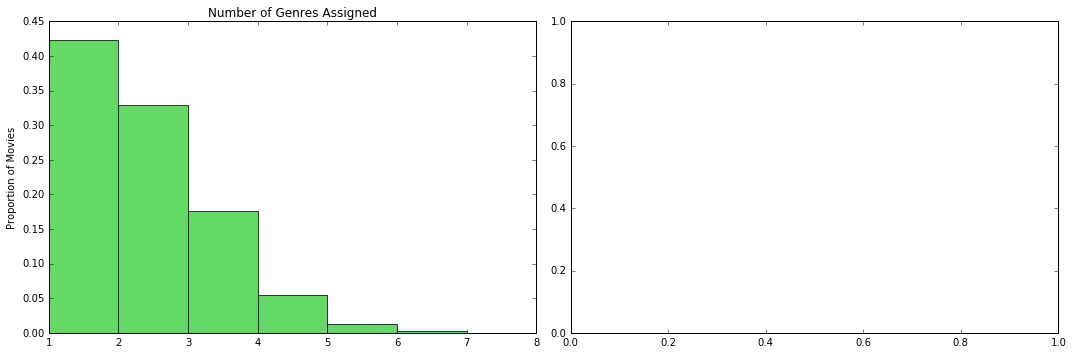

In [38]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
ax1.hist(genres['num_genres'], normed=1, facecolor='limegreen', alpha=0.75)
ax1.set_xlim([1,8])
ax1.set_title('Number of Genres Assigned')
ax1.set_ylabel('Proportion of Movies')



plt.tight_layout()
plt.show()

From the plot above, we can see that there is imbalanced data, as there are a lot more () movies than () movies. To address this issue, we will employ **class weighting** in our models.

---

## Next Steps

Moving forward, we will split the dataset into training and testing sets. Then, we will train classification models with traditional machine learning methods, such as random forest and support vector machine, and evaluate their performance on the test set. We will consider and explain what we want to use as our performance metric(s). 

---